<a href="https://colab.research.google.com/github/arpitvaghela/DSA_FL/blob/main/Copy_of_FL_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM time series prediction using Federated Learning

## Imports

In [1]:
!pip install --quiet --upgrade tensorflow_federated_nightly
!pip install --quiet --upgrade nest_asyncio

import nest_asyncio
nest_asyncio.apply()

     |████████████████████████████████| 532kB 9.3MB/s 
     |████████████████████████████████| 153kB 31.5MB/s 
     |████████████████████████████████| 112kB 43.9MB/s 
     |████████████████████████████████| 174kB 54.9MB/s 
     |████████████████████████████████| 3.0MB 45.8MB/s 
     |████████████████████████████████| 1.1MB 58.5MB/s 
     |████████████████████████████████| 394.9MB 43kB/s 
     |████████████████████████████████| 471kB 54.5MB/s 
     |████████████████████████████████| 1.3MB 45.7MB/s 
     |████████████████████████████████| 10.6MB 45.2MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: tf-nightly 2.5.0.dev20201106 has requirement absl-py~=0.10, but you'll have absl-py 0.9.0 which is incompatible.
ERROR: tf-nightly 2.5.0.dev20201106 has requirement grpcio~=1.32.0, but you'll have grpcio 1.29.0 which is incompatible.
ERROR: tf-nightly 2.5.0.dev20201106 has requirement numpy~=1.19.2, but you'll have numpy 1

In [2]:
import collections
import functools
import os
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf

np.random.seed(0)

In [3]:
import tensorflow_federated as tff

# Test the TFF is working:
tff.federated_computation(lambda: 'Hello, World!')()

/usr/local/lib/python3.6/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:43: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20201106). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


b'Hello, World!'

## Data preprocessing


In [4]:
#FM = np.fromfile('96_7_20db',dtype=np.float32)
N = 10**6
FM = np.random.randn(N) # normal distributed channel
FM.reshape(-1,1) 

array([[ 1.76405235],
       [ 0.40015721],
       [ 0.97873798],
       ...,
       [-0.79728264],
       [ 0.87475609],
       [ 1.37183066]])

### Bandpower Equation


In [5]:
def bandpower(signal:np.array)->np.float:
  return np.mean(signal ** 2)

In [6]:
bandpower(FM)

0.9998449448099948

### awgn Function

Function to add noise to the signal resulting in given S/N ratio

In [7]:
def awgn(signal:np.ndarray, desired_snr:int):
  """Add AWGN noise to generate signal with given SNR. 
  """
  # Converting the SNR from dB scale to linear scale
  snr_linear = math.pow(10, desired_snr / 10)
  
  # Standard normally distributed noise
  noise = np.random.randn(signal.shape[0], 1)
  
  # Using the boxed formula
  var_signal = bandpower(noise) * snr_linear
  
  # Normalizing the signal to have the given variance
  normalized_signal = math.sqrt(var_signal) * (signal / math.sqrt(bandpower(signal)))
  
  #print("SNR = " + str(10 * math.log10(bandpower(normalized_signal) / bandpower(noise))))
  
  return normalized_signal + noise

## Filtering Data

filtering data points to be in range $10^{-7}< signal< 1$

In [8]:
FM = FM[np.logical_and(FM > math.pow(10, -7), FM < 1)]
FM = FM.reshape(FM.shape[0], 1)
print("Size of FM: " + str(FM.shape))

Size of FM: (342135, 1)


## Creating Dataset

- take datapoints of size, _samples*sample_size_

- add noise with desire snr

- sample = $[s_1,s_2,\cdots,s_N]$

- Energy detection = $\sum_{i=1}^{N}s_i^2$

- $X[j]$ = $\sum_{i=j*N+1}^{(j+1)*N}s_i^2$

In [9]:
def create_dataset(signal, desired_snr, samples, sample_size):
  
  # Creating the signal with desired SNR
  snr_signal = awgn(signal[0:samples * sample_size], desired_snr)
  
  # Allocating zeros to the dataset
  X = np.zeros((samples, 1))
  
  for i in range(0, samples):
    
    # Extracting the sample based on sample size
    sampled_signal = snr_signal[i * sample_size : (i + 1) * sample_size]
    
    # Sorting the sampled signal
    sampled_signal = np.sort(sampled_signal, axis=0)
    
    # Energy detection
    E = np.sum(sampled_signal ** 2)
    
    # Assigning values to the dataset
    X[i][0] = E
  
  return X

In [10]:
%%time
# sample dataset for SNR=4

print(create_dataset(FM[50000:], 4, 15000, 100).shape)

(15000, 1)
CPU times: user 168 ms, sys: 26 µs, total: 168 ms
Wall time: 169 ms


In [11]:
def final_dataset(signal, snr_range, samples_per_snr, sample_size):
  X = {}
  
  for snr in snr_range:
    # Creating dataset for the given SNR
    X_snr = create_dataset(signal, snr, samples_per_snr, sample_size)
    
    # Indexing within the final dataset matrix X
    X[snr] = X_snr
  
  return X

## Generating White Noise Sequence 

In [12]:
def create_noise_sequence(samples, sample_size):
  
  # Creating white noise sequence of variance 1
  noise = np.random.randn(samples * sample_size, 1)
  
  # Allocating zeros to the dataset
  X = np.zeros((samples, 1))
  
  for i in range(0, samples):
    
    # Extracting the sample based on sample size
    sampled_signal = noise[i * sample_size : (i + 1) * sample_size]
    
    # Sorting the sampled signal
    sampled_signal = np.sort(sampled_signal, axis=0)
    
    # Energy detection
    E = np.sum(sampled_signal ** 2)
    
    # Assigning values to the dataset
    X[i][0] = E
  
  return X

## DataSet LookBack for RNN

In [17]:
# Function for Chaning the dataset for look back  #linear dataset initially
def create_look_back(X, look_back=1):
  
  # Look back dataset is initialized to be empty
  look_back_X = []
  
  for i in range(len(X) - look_back + 1):
    # Extracting an example from the dataset
    a = X[i:(i + look_back), :]
    
    a = a.flatten() # (For flattening) #1D list
    
    # Appending to the dataset
    look_back_X.append(a)
  
#  look_back_Y = []
    
  # Returning in numpy's array format
  return np.array(look_back_X)

In [19]:
def dataset_look_back(X_tech, snr_range, look_back):
  X_tech_lb = {}
  
  # Look backs for all SNRs
  for snr in snr_range:
    X_tech_lb[snr] = create_look_back(X_tech[snr], look_back)
  
  return X_tech_lb

In [156]:
def generate_Dataset(FM,snr_ratio=(0.8, 0.2),sample_size=100):
  lsnr_range=(-20,-4)
  hsnr_range=(-4,6)
  look_back = 2
  N = len(FM)
  
  no_of_sample_hsnr = int((N*snr_ratio[0])//((hsnr_range[1] - hsnr_range[0])/2))
  no_of_sample_lsnr = int((N*snr_ratio[1])//((lsnr_range[1] - lsnr_range[0])/2))
  
  X_FM = {**final_dataset(FM, range(lsnr_range[0],lsnr_range[1], 2),no_of_sample_lsnr, sample_size),
          **final_dataset(FM, range(hsnr_range[0],hsnr_range[1], 2), no_of_sample_hsnr, sample_size)}

  X_noise = create_noise_sequence(N, sample_size)

  # lookback

  X_FM_lb = dataset_look_back(X_FM, range(-20, 6, 2), look_back)
  X_noise_lb = create_look_back(X_noise, look_back)

  # final X_train and y

  X = X_FM_lb[-20]
  y = []

  for snr in range(-18, 6, 2):
    X = np.concatenate((X, X_FM_lb[snr]), axis=0)

  y = np.ones((X.shape[0], 1))
 
  # print(X.shape)
  # print(X_noise_lb.shape)
  X = np.concatenate((X, X_noise_lb), axis=0)
  y_train = np.concatenate((y, np.zeros((X_noise_lb.shape[0], 1))))

  
  # reshape
  X_train = np.reshape(X, (-1, 2, 1))
  Y_train = np.reshape(y_train,(-1,1,1))

  index = [i for i in range(len(X_train))]
  np.random.shuffle(index)

  X_train = np.array([X_train[i] for i in index])
  Y_train = np.array([Y_train[i] for i in index])
  
  return X_train,Y_train

 

In [158]:
# created dataset
X,Y = generate_Dataset(FM)

In [160]:
print("Shape of X,Y :",X.shape,Y.shape) # similar to the shape we have

# train,test split
train_size = int(len(X)*0.80)
test_size = len(X) - train_size

X_train, X_test = X[:train_size,:,:],X[train_size:,:,:]
Y_train, Y_test = Y[:train_size,:,:],Y[train_size:,:,:]


print(X_train.shape,X_test.shape)
print(Y_train.shape,Y_test.shape)


Shape of X,Y : (684250, 2, 1) (684250, 1, 1)
(547400, 2, 1) (136850, 2, 1)
(547400, 1, 1) (136850, 1, 1)


In [161]:
X_train[0],Y_train[0]

(array([[0.],
        [0.]]), array([[1.]]))

## LSTM model and training

In [162]:
model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(4,input_dim=1),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [216]:
model.fit(X_train,Y_train,validation_split=0.25,epochs=10,verbose=1)

model.evaluate(X_test,Y_test,verbose=1)

Epoch 1/10
12830/12830 [==============================] - 31s 2ms/step - loss: 0.2088 - accuracy: 0.9348 - val_loss: 0.2030 - val_accuracy: 0.9344
Epoch 2/10
12830/12830 [==============================] - 31s 2ms/step - loss: 0.2004 - accuracy: 0.9356 - val_loss: 0.2031 - val_accuracy: 0.9344
Epoch 3/10
12830/12830 [==============================] - 31s 2ms/step - loss: 0.2004 - accuracy: 0.9356 - val_loss: 0.2030 - val_accuracy: 0.9344
Epoch 4/10
12830/12830 [==============================] - 31s 2ms/step - loss: 0.2004 - accuracy: 0.9356 - val_loss: 0.2030 - val_accuracy: 0.9344
Epoch 5/10
12830/12830 [==============================] - 31s 2ms/step - loss: 0.2004 - accuracy: 0.9356 - val_loss: 0.2030 - val_accuracy: 0.9344
Epoch 6/10
12830/12830 [==============================] - 31s 2ms/step - loss: 0.2004 - accuracy: 0.9356 - val_loss: 0.2030 - val_accuracy: 0.9344
Epoch 7/10
12830/12830 [==============================] - 32s 2ms/step - loss: 0.2004 - accuracy: 0.9356 - val_loss: 0

[0.2040516436100006, 0.9338253736495972]

## LSTM model test

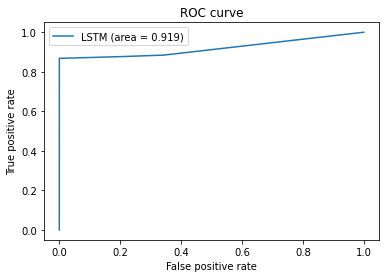

In [217]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

Y_pred = model.predict(X_test).ravel()
Y_pred.reshape(-1,1)
fpr, tpr, threshold = roc_curve(Y_test.reshape(-1,1), Y_pred) 
auc = auc(fpr,tpr)
plt.plot(fpr, tpr, label='LSTM (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()

## Federated Training and preprocessing centrailized data

### Generating a decentralized data

In [218]:
T_CLIENTS = 500
CLIENT_SAMPLE_SIZE = len(X_train)/T_CLIENTS
step = len(X_train)/T_CLIENTS

data_fed = [ tf.data.Dataset.from_tensor_slices(
         {
          "value":X_train[int(i*step):int((i+1)*step)],
          "label":Y_train[int(i*step):int((i+1)*step)]
        }
     ) for i in range(T_CLIENTS)]

# client dataset can be accesed as data_fed[ CLIENT_ID ]
example_dataset = data_fed[0]

#   def preprocess(data_fed):
#   def batch_format_fn(ele):

example_element = next(iter(example_dataset))

print(example_element["value"].numpy()) # example_element[0] refers to X val
print(example_element["label"].numpy()) # example_element[1] refers to X val

[[0.]
 [0.]]
[[1.]]


In [219]:
# preprocess

NUM_CLIENTS = T_CLIENTS
NUM_EPOCHS = 5
BATCH_SIZE = int(CLIENT_SAMPLE_SIZE//2)
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):
  
  def batch_format_fn(element):
    return collections.OrderedDict(
        x=element["value"],
        y=element["label"]
    )
  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)


In [220]:

preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch["x"].shape

(547, 2, 1)

In [221]:
def make_federated_data(client_data,client_ids):
  return [
      preprocess(client_data[x])
      for x in client_ids
  ]


In [222]:
sample_clients = [x for x in range(NUM_CLIENTS)]

federated_train_data = make_federated_data(data_fed, sample_clients)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))


Number of client datasets: 500
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 2, 1)), (y, (None, 1, 1))]), types: OrderedDict([(x, tf.float64), (y, tf.float64)])>


### Creating the Iterative process

In [223]:
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

def model_fn():
  keras_model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(4,input_dim=1),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  return tff.learning.from_keras_model(
    keras_model,
    input_spec=preprocessed_example_dataset.element_spec,
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
  )

iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

str(iterative_process.initialize.type_signature)


'( -> <model=<trainable=<float32[1,16],float32[4,16],float32[16],float32[4,1],float32[1]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<value_sum_process=<>,weight_sum_process=<>>,model_broadcast_state=<>>@SERVER)'

In [224]:
state = iterative_process.initialize()
test_model = tf.keras.models.clone_model(model)
test_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.SGD(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

def keras_evaluate(state, round_num):
  state.model.assign_weights_to(test_model)
  loss, accuracy = test_model.evaluate(X_test,Y_test, steps=2, verbose=0)
  print('\tEval: loss={l:.3f}, accuracy={a:.3f}'.format(l=loss, a=accuracy))

### Iterations

In [230]:
NUM_ROUNDS = 21
CLIENT_PER_ROUND = 25
for round_num in range(1, NUM_ROUNDS):
  # 500 clients are selected for training in various rounds
  # there are 10 rounds and each round takes data from 50 clients

  clients = [round_num*x for x in range(1,CLIENT_PER_ROUND)]
  federated_train_data = make_federated_data(data_fed, clients)
  
  print("ROUND ",round_num)
  keras_evaluate(state, NUM_ROUNDS + 1) # eval before hand
  state, metrics = iterative_process.next(state, federated_train_data)
  print('\tTrain: loss={}, accuracy={} '.format(round_num, metrics["train"]["loss"],metrics["train"]["binary_accuracy"]))

keras_evaluate(state, NUM_ROUNDS + 1)

ROUND  1
	Eval: loss=0.183, accuracy=0.934
	Train: loss=1, accuracy=0.18180041015148163 
ROUND  2
	Eval: loss=0.182, accuracy=0.934
	Train: loss=2, accuracy=0.17999771237373352 
ROUND  3
	Eval: loss=0.180, accuracy=0.934
	Train: loss=3, accuracy=0.17907977104187012 
ROUND  4
	Eval: loss=0.179, accuracy=0.934
	Train: loss=4, accuracy=0.1767006367444992 
ROUND  5
	Eval: loss=0.177, accuracy=0.934
	Train: loss=5, accuracy=0.1758982241153717 
ROUND  6
	Eval: loss=0.176, accuracy=0.934
	Train: loss=6, accuracy=0.1740993708372116 
ROUND  7
	Eval: loss=0.174, accuracy=0.934
	Train: loss=7, accuracy=0.17320339381694794 
ROUND  8
	Eval: loss=0.173, accuracy=0.934
	Train: loss=8, accuracy=0.17084282636642456 
ROUND  9
	Eval: loss=0.172, accuracy=0.934
	Train: loss=9, accuracy=0.16996632516384125 
ROUND  10
	Eval: loss=0.170, accuracy=0.934
	Train: loss=10, accuracy=0.1688462793827057 
ROUND  11
	Eval: loss=0.169, accuracy=0.934
	Train: loss=11, accuracy=0.16730071604251862 
ROUND  12
	Eval: loss

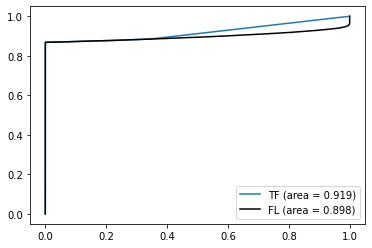

In [231]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# tensorflow LSTM 
Y_pred = model.predict(X_test).ravel()
Y_pred.reshape(-1,1)
fpr, tpr, threshold = roc_curve(Y_test.reshape(-1,1), Y_pred) 
auc_tf = auc(fpr,tpr)
plt.plot(fpr, tpr, label='TF (area = {:.3f})'.format(auc_tf))


# Federated Learning
state.model.assign_weights_to(test_model)

Y_pred_FL = test_model.predict(X_test).ravel()
Y_pred_FL.reshape(-1,1)
fpr_FL, tpr_FL, threshold_FL = roc_curve(Y_test.reshape(-1,1), Y_pred_FL) 
auc_tff = auc(fpr_FL,tpr_FL)
plt.plot(fpr_FL, tpr_FL,'k', label='FL (area = {:.3f})'.format(auc_tff))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()